# LLM Evaluation & Alignment

**Chris Zhu**  
Yale University | Becoming Full-Stack AI Researchers Working Group  
November 4, 2025

---

## Part 1: The LLM Benchmark Landscape 

### 1.1 What is an LLM Benchmark?

A benchmark is a **standardized test** designed to measure specific capabilities of language models:

- What can the model do?
- How well does it perform?
- Where does it fail?
- How does it compare to others?

**Key insight:** Benchmarks shape how we understand progress in AI.

### 1.2 Exploring the Ecosystem: Epoch AI Benchmarks

Let's look at the current landscape through [Epoch AI's Benchmark Database](https://epoch.ai/benchmarks):

**Major Categories:**

| Category | Examples | What they measure |
|----------|----------|------------------|
| Knowledge & Reasoning | MMLU, BBH, ARC | Factual knowledge, logical reasoning |
| Math & Code | GSM8K, MATH, HumanEval | Quantitative reasoning, programming |
| Language Understanding | HellaSwag, PIQA | Commonsense, context understanding |
| Multi-modal | MMMU, VQA | Vision-language integration |

### 1.3 The Core Problem: Saturation

**Three fundamental issues with traditional benchmarks:**

1. **Rapid saturation** - Models quickly reach near-perfect scores
2. **Data contamination** - Test sets leak into training data
3. **Lack of construct validity** - High scores don't always mean genuine capability

**Example:** GPT-4 exceeds human performance on MMLU, but does this mean it's "smarter" than humans?

### 1.4 Modern Evaluation Frameworks

**Key packages in the ecosystem:**

| Package | Organization | Key Feature |
|---------|-------------|-------------|
| **lm-eval-harness** | EleutherAI | Academic benchmarks, 200+ tasks, unified interface |
| **HELM** | Stanford | Holistic metrics across scenarios, Capabilities + bias + safety + efficiency |
| **inspect_ai** | UK AISI | Behavioral & agent evals, Trace-level analysis, deception/safety experiments|
| **OpenAI Evals** | OpenAI | Production-ready, community-driven, CI-style evaluation, LLM-as-judge |

2025-11-04:16:42:04,136 INFO     [huggingface.py:162] Using device 'mps'
2025-11-04:16:42:06,575 INFO     [evaluator.py:131] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
Running loglikelihood requests:  68%|██████▊   | 5429/7997 [37:56<17:56,  2.38it/s]
2025-11-04:16:42:12,925 WARNING  [evaluator.py:222] Overwriting default num_fewshot of arc_easy from None to 0
2025-11-04:16:42:12,925 WARNING  [evaluator.py:222] Overwriting default num_fewshot of hellaswag from None to 0
2025-11-04:16:42:12,926 INFO     [task.py:395] Building contexts for arc_easy on rank 0...
100%|██████████| 100/100 [00:00<00:00, 2980.01it/s]
2025-11-04:16:42:12,964 INFO     [task.py:395] Building contexts for hellaswag on rank 0...
100%|██████████| 100/100 [00:00<00:00, 7447.14it/s]
2025-11-04:16:42:12,987 INFO     [evaluator.py:362] Running loglikelihood requests
Running loglikelihood requests: 100%|██████████| 799/799 [00:11<00:00, 69.02it/s] 
fatal: not a git reposito


=== RAW RESULTS KEYS ===
    arc_easy -> ['acc,none', 'acc_stderr,none', 'acc_norm,none', 'acc_norm_stderr,none', 'alias']
   hellaswag -> ['acc,none', 'acc_stderr,none', 'acc_norm,none', 'acc_norm_stderr,none', 'alias']

=== RAW RESULTS (truncated) ===
{'arc_easy': {'acc,none': 0.38,
              'acc_norm,none': 0.34,
              'acc_norm_stderr,none': 0.04760952285695233,
              'acc_stderr,none': 0.04878317312145634},
 'hellaswag': {'acc,none': 0.36,
               'acc_norm,none': 0.44,
               'acc_norm_stderr,none': 0.049888765156985884,
               'acc_stderr,none': 0.048241815132442176}}

 Evaluation Results
hellaswag: 36.0%  (acc,none)
arc_easy: 38.0%  (acc,none)

 Demo complete.

📈 Figure saved to: results/lm_eval_demo_plot.png


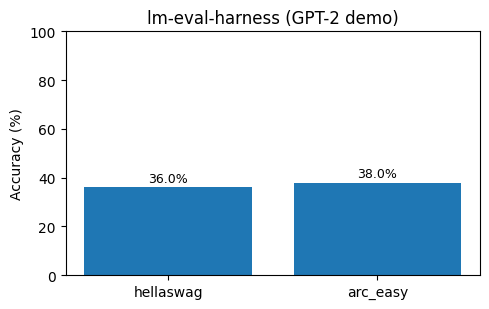

In [16]:
"""
Robust lm-eval-harness demo:
- Runs GPT-2 on two classic reasoning benchmarks:
    * HellaSwag: commonsense completion (choose most plausible ending)
    * ARC-Easy: grade-school science questions (multiple choice)
- Works on CPU or Apple Silicon (MPS)
- Prints RAW metric keys for transparency
- Extracts accuracy cleanly across lm-eval versions
"""

import os
# Avoid CUDA probing and silence tokenizers fork warnings
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from pprint import pprint
import torch
from lm_eval import simple_evaluate
from lm_eval.models.huggingface import HFLM

# Choose execution device:
# - Prefer MPS (Apple Silicon GPU) if available; otherwise use CPU
device = "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else "cpu"

# Load a small local model (no API keys required)
model = HFLM(
    pretrained="gpt2",
    device=device,
    dtype="float32",        # safe, portable precision for CPU/MPS
    use_fast_tokenizer=True
)

# Run a reasonably fast demo (increase/remove `limit` for full eval)
results = simple_evaluate(
    model=model,
    tasks=["hellaswag", "arc_easy"],
    num_fewshot=0,          # zero-shot
    batch_size=8,
    limit=100,             # demo speed; set to None for full benchmark
)

# --- Inspect raw results so we know which metric keys exist ---
print("\n=== RAW RESULTS KEYS ===")
for task, vals in results["results"].items():
    print(f"{task:>12} -> {list(vals.keys())}")
print("\n=== RAW RESULTS (truncated) ===")
pprint({k: {kk: vv for kk, vv in v.items() if isinstance(vv, (int, float))}
        for k, v in results["results"].items()})

# --- Flexible metric extraction (covers common variants across versions) ---
def get_metric(res, task):
    """
    Return (value, key) for the main 'accuracy-like' metric if found.
    Falls back to the first numeric ratio in [0,1].
    """
    task_res = res["results"].get(task, {})
    preferred = ("acc_norm", "acc", "accuracy", "multiple_choice_grade", "acc,none")
    for k in preferred:
        v = task_res.get(k, None)
        if isinstance(v, (int, float)) and 0.0 <= v <= 1.0:
            return v, k
    # Fallback: any numeric ratio in [0,1]
    for k, v in task_res.items():
        if isinstance(v, (int, float)) and 0.0 <= v <= 1.0:
            return v, k
    return None, None

def display(task):
    val, key = get_metric(results, task)
    if val is None:
        print(f"{task}: ❓ metric unavailable (see RAW RESULTS KEYS above)")
    else:
        print(f"{task}: {val:.1%}  ({key})")

print("\n Evaluation Results")
display("hellaswag")
display("arc_easy")
print("\n Demo complete.\n")

# --- quick plot  ---
try:
    import matplotlib.pyplot as plt
    pairs = []
    for t in ("hellaswag", "arc_easy"):
        v, k = get_metric(results, t)
        if v is not None:
            pairs.append((t, v * 100.0, k))
    if pairs:
        plt.figure(figsize=(5, 3.2))
        xs = [p[0] for p in pairs]
        ys = [p[1] for p in pairs]
        bars = plt.bar(xs, ys)
        plt.ylim(0, 100)
        plt.ylabel("Accuracy (%)")
        plt.title("lm-eval-harness (GPT-2 demo)")
        for b, pct in zip(bars, ys):
            plt.text(b.get_x() + b.get_width()/2, b.get_height() + 1, f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)
        os.makedirs("results", exist_ok=True)
        out_path = "results/lm_eval_demo_plot.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=150)
        print(f"📈 Figure saved to: {out_path}")
        plt.show()
    else:
        print("⚠️ No numeric accuracy metrics available to plot.")
except Exception as e:
    print(f"Plot skipped ({e})")

### 1.5 Case Study: SWE-bench Evolution

**SWE-bench** (Software Engineering Benchmark) - A real-world coding benchmark

**Live site:** https://www.swebench.com/

**Original Version (Princeton, 2024):**
- Task: Solve real GitHub issues from 12 Python repositories
- Dataset: 2,294 issue-pull request pairs
- Metric: Can the model generate a patch that passes all tests?
- Initial result: GPT-4 achieved only **1.7% success rate**

**Why so low?** This is a genuinely hard task requiring:
- Understanding large codebases
- Debugging complex issues
- Generating working code patches

### 1.6 SWE-bench: The Refinement Cycle

**Problems discovered with the original benchmark:**

1. **Data contamination** - Models may have seen GitHub repositories during pre-training
2. **Instance quality issues** - A subset of GitHub issues were **underspecified or ambiguous**, and some test suites had **flake or setup quirks**
3. **Evaluation noise** - Docker/test execution environment sometimes produced **non-deterministic outcomes** 

**SWE-bench Lite (Princeton, 2024):**
- Curated subset of 300 high-quality, verified instances
- Removed problems with ambiguous specifications
- More stable test execution
- GPT-4: ~3-5% (still challenging)

**SWE-bench Verified (OpenAI, 2024):**
- Manual verification of each instance
- Human expert validation
- 500 instances with clear acceptance criteria
- Added human baseline for comparison

**The pattern:** Even carefully designed benchmarks need iterative refinement based on real-world usage.

---

## Part 2: DealBench - Adversarial Evaluation

### 2.1 The Paradigm Shift: From Static to Adversarial

**Why do benchmarks keep failing?**

| Traditional Benchmarks | Problem |
|----------------------|----------|
| Fixed answer keys | Memorization, data leakage |
| Single-turn evaluation | Misses interactive intelligence |
| Static difficulty | Rapid saturation |

**What if we design a benchmark that:**
- Has **no fixed answers** (outcome depends on opponent)
- Measures **strategic interaction** (multi-turn, adaptive)
- **Resists saturation** (difficulty scales with opponent strength)

### 2.2 Introducing DealBench

**DealBench:** An adversarial negotiation benchmark built on realistic MBA business cases.

**Core idea:** Evaluate models by having them negotiate with each other.

**Why negotiation?**
- Clear economic outcomes (measurable value creation)
- No single "correct" answer (opponent-dependent)
- Tests strategic reasoning, theory of mind, multi-turn planning
- Exposes safety-relevant behaviors (lying, rule-breaking)

### 2.3 Formal Framework

Let's formalize a negotiation:

**Setup:**
- Issue space: $\Omega$ (e.g., salary, start date, location, bonuses)
- Utility functions: $u_i : \Omega \to \mathbb{R}$ for each party $i$
- BATNA (Best Alternative to Negotiated Agreement): $b_i$ = value of walking away

**Zone of Possible Agreement (ZOPA):**

$$\mathcal{Z} = \{\omega \in \Omega : u_i(\omega) > b_i \text{ for all } i\}$$

**Total Pie (value created):**

$$P(\omega) = \sum_i (u_i(\omega) - b_i)$$

**Pie Fraction (relative share):**

$$p_i(\omega) = \frac{u_i(\omega) - b_i}{P(\omega)} \in [0,1], \quad \sum_i p_i(\omega) = 1$$

### 2.4 Three Canonical Negotiation Types

**1. No-ZOPA Case**

- Scenario: A historic property where buyer wants redevelopment but seller requires preservation
- $\mathcal{Z} = \emptyset$ (no mutually acceptable deal exists)
- **Test:** Can the model recognize when no deal is possible?

---

**2. Zero-Sum Single-Issue**

- Scenario: Contractor vs homeowner negotiating price for tree removal
- Only one issue: price
- $\sum_i u_i(\omega) = \text{constant}$ (pure distributive bargaining)
- **Test:** Can the model claim value effectively?

---

**3. Multi-Issue Positive-Sum**

<img src="./figures/muiti_issue.png" width="700">

- Scenario: Job offer negotiation (salary, start date, location, bonuses, division)
- Multiple issues with different priorities for each party
- Potential for "elegant trades" that expand total value
- **Test:** Can the model discover integrative solutions?

### 2.5 Evaluation Methodology: Two Types of Play

**We evaluate models using two complementary approaches:**

#### 2.5.1 Mirror Play (Model vs Itself)

**Setup:**
- Same model plays both sides of the negotiation
- Tests value creation ability in a controlled setting
- Used for comparison with human baseline

**Key Metric: Total Pie**
$$P(\omega) = \sum_i (u_i(\omega) - b_i)$$
How much joint value is created above both parties' BATNAs?

**Benchmark: MBA Students**
- Collected human baseline on identical negotiation cases
- MBA students at Yale School of Management
- Same scenarios, same constraints, same evaluation

**Finding:** Top models significantly outperform MBA students


---

#### 2.5.2 Cross Play (Model vs Model)

**Setup:**
- Every model negotiates against every other model
- Tests strategic adaptation and competitive performance
- Reveals relative strengths across different opponents

**Key Metric: Pie Fraction**
$$p_i(\omega) = \frac{u_i(\omega) - b_i}{P(\omega)}$$
What share of the jointly created value does each model capture?

**Purpose:**
- Rank models by negotiation skill
- Identify which models are better at claiming value
- Test robustness across diverse opponents


---

**Why both metrics matter:**

| Metric | What it measures | Economic interpretation |
|--------|------------------|------------------------|
| Total Pie | Joint value creation | Efficiency (finding win-win solutions) |
| Pie Fraction | Value distribution | Bargaining power (claiming your share) |



### 2.9 Live Demo

**Let's see DealBench in action!**

I'll now switch to the terminal and run:

```bash
python -m negbench\
  --scenario scenarios/SnyderMed.yaml \
  --n-runs 1 \
  --rounds 6 \
  --models anthropic/claude-3.5-sonnet,openai/gpt-4o \
  --no-use-plan \
  --no-use-memory \
  --exp-name 2025-11-04_Demo \
  --verbose
```

**What you'll observe:**
- Two LLMs negotiating a job offer
- Multi-turn offers and counteroffers
- Deal closure or walk-away
- Automatic value calculation and compliance checks

[LIVE DEMO SECTION - TERMINAL]

## Part 3: From Evaluation to Alignment 

### 3.1 From Measuring Quality to Improving Quality

**So far, we've focused on evaluation:**
- How do we measure if a model is good?
- Traditional benchmarks: fixed tests
- DealBench: adversarial interaction

**Now, a natural next question:**
- How do we make models better?
- Specifically: How do we train models to be helpful, harmless, and honest?

**In alignment:**
- Which summary is more helpful? → Depends on user needs
- Is this response appropriate? → Depends on context and values

**The insight:** If we can systematically judge preferences, we can use those judgments to improve models.

**This is the foundation of modern alignment techniques: RLHF and RLAIF.**

### 3.2 The Alignment Problem

**Goal:** Train models to produce outputs that humans prefer.

**Challenge:** 
- Preference is subjective (what's "helpful" or "harmless"?)
- Hard to specify formally
- Context-dependent

**Traditional approach: RLHF (Reinforcement Learning from Human Feedback)**

1. Collect human preference labels on pairs of model outputs
2. Train a reward model to predict human preferences
3. Use RL to optimize policy against the reward model

**The bottleneck:** Human annotation is expensive and slow!

### 3.3 RLAIF: RL from AI Feedback

**Core question:** Can we use a strong LLM to generate preference labels instead of humans?

<img src="./figures/RLHF.png" width="1000">

**RLAIF Pipeline:**

1. Start with supervised fine-tuned (SFT) model
2. Generate response pairs
3. **AI labeler** (e.g., PaLM 2 Large) judges which response is better
4. Train reward model on AI preferences
5. Run RL to optimize policy

**Key difference:** Replace human annotators with an off-the-shelf LLM.

### 3.4 How to Get AI Preferences

**Prompt structure for AI labeler:**

**Step 1: Preamble**  
*A good summary is concise, accurate, and covers key information...*

**Step 2: Sample to Annotate**  
- Text: [original Reddit post]  
- Summary 1: [candidate A]  
- Summary 2: [candidate B]

**Step 3: Chain-of-Thought Prompt**  
*Consider coherence, accuracy, coverage. Explain which summary is better.*

**Step 4: LLM Output**  
*Rationale: [LLM generates reasoning explaining its preference]*

**Step 5: Final Preference**  
*Preferred Summary: [1 or 2]*

---

**Key techniques:**
- **Chain-of-thought reasoning** improves alignment (+1.9%)
- **Position debiasing** (run twice with reversed order)
- **Extract log-probabilities** for soft labels

### 3.5 Mathematical Framework: From Preferences to Aligned Models

Now that we have AI-generated preferences, how do we use them to train better models?

**Two-stage process:**

---

#### Stage 1: Training the Reward Model

**Goal:** Learn to predict which response is better

**Input:** Preference dataset $\mathcal{D} = \{(x, y_w, y_l)\}$ where:
- $x$ = prompt (e.g., "Summarize this article")
- $y_w$ = preferred response (higher quality)
- $y_l$ = less preferred response (lower quality)

**Model:** Train a reward function $r_\phi(x, y)$ that assigns scores to responses

**Training objective:**

$$\mathcal{L}_r(\phi) = -\mathbb{E}_{(x,y_w,y_l)\sim\mathcal{D}}\left[\log \sigma(r_\phi(x, y_w) - r_\phi(x, y_l))\right]$$

**Intuition:** Maximize the probability that $r(y_w) > r(y_l)$

**Example:**

| | Prompt | Response | Reward Score |
|---|--------|----------|--------------|
| **Preferred** | "Write a polite email" | *"Dear Sir, I hope this email finds you well..."* | $r = 2.3$ ⬆ |
| **Not preferred** | "Write a polite email" | *"Hey, here's what I need..."* | $r = -0.8$ ⬇ |

After training, the reward model learns that formal language gets higher scores.

---

#### Stage 2: Reinforcement Learning with KL Penalty

**Goal:** Train policy to generate high-reward (= high-quality) responses

**Challenge:** If we only maximize reward, the model might "cheat"

**Why KL Penalty Matters: Preventing Reward Hacking**

Consider what could go wrong without constraints:

| Scenario | Model Output | Reward Model | Reality |
|----------|--------------|--------------|---------|
| **Without penalty** | *"This AMAZING article presents INCREDIBLE findings with PHENOMENAL clarity!!!"* | High score  (positive words) |  Useless word salad |
| **With KL penalty** | *"The study found three key results: X, Y, and Z"* | Good score  |  Actually helpful |

**Solution:** Add a KL divergence penalty to keep the model reasonable

**RL objective:**

$$J(\theta) = \mathbb{E}_{y\sim\pi_\theta(\cdot|x)}\left[\underbrace{(1-\beta)r_\phi(y|x)}_{\text{maximize reward}} - \underbrace{\beta \cdot D_{KL}(\pi_\theta \| \pi_{\text{SFT}})}_{\text{stay close to SFT}}\right]$$

**Components explained:**

| Symbol | Meaning | Intuition |
|--------|---------|-----------|
| $\pi_\theta$ | Policy being trained | The model we're improving |
| $r_\phi(y\|x)$ | Reward for response $y$ | How good is this response? |
| $\pi_{\text{SFT}}$ | Original SFT model | Safe baseline model |
| $D_{KL}$ | KL divergence | How much has the model changed? |
| $\beta$ | Penalty coefficient | Controls the trade-off (typically 0.05) |

**The trade-off:**

- **High reward term $(1-\beta)r_\phi$:** Generate responses humans prefer
- **KL penalty $-\beta D_{KL}$:** Don't drift too far from the safe baseline

**Why KL divergence matters:**

$$D_{KL}(\pi_\theta \| \pi_{\text{SFT}}) = \mathbb{E}_y\left[\log \frac{\pi_\theta(y|x)}{\pi_{\text{SFT}}(y|x)}\right]$$

- Small $D_{KL}$ → Model stays similar to SFT (conservative, safe)
- Large $D_{KL}$ → Model becomes very different (risky, might generate nonsense)

---

#### Choosing $\beta$: The Safety-Performance Trade-off

| $\beta$ | Behavior | Example |
|---------|----------|---------|
| 0.0 | Pure reward maximization | "BEST SUMMARY EVER!!!" (reward hacking) |
| 0.05 | **Balanced (typical choice)** | Good improvements, stays reasonable |
| 0.2 | Conservative | Safe but limited improvement |
| 1.0 | No change from SFT | Ignores reward completely |

**In the RLAIF paper:** $\beta = 0.05$ works well across all tasks

---

#### Training Algorithm

**Objective at each step:**

$$J(\theta) = (1-\beta) r_\phi(x,y) - \beta \cdot D_{KL}(\pi_\theta \| \pi_{\text{SFT}})$$

**Process:**

1. Sample prompt $x$ from dataset
2. Generate response $y \sim \pi_\theta(\cdot|x)$ from current policy
3. Score with reward model: $r_\phi(x, y)$
4. Compute KL divergence: $D_{KL}(\pi_\theta \| \pi_{\text{SFT}})$
5. Update parameters: $\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)$
6. Repeat for approximately 10,000 steps

**Typical hyperparameters:** $\beta = 0.05$, learning rate $\alpha = 10^{-5}$

**Result:** A model that generates high-quality responses while staying grounded

### 3.6 Main Result: RLAIF Matches RLHF


**Experiment:** Train models on three tasks and compare final outputs via human evaluation


| Task | RLAIF vs SFT | RLHF vs SFT | RLAIF vs RLHF |
|------|--------------|-------------|---------------|
| Summarization | 71% | 73% | 50% (tie) |
| Helpful Dialogue | 63% | 64% | 52% (tie) |
| Harmless Dialogue | 88% | 76% | **RLAIF wins** |

**Key finding:** AI feedback is competitive with human feedback.

**Implications:**
- 10x cheaper than human annotation
- Faster iteration cycles
- Scales better

---


**The bigger picture:** We're moving toward **self-improving, adversarially-tested AI systems**.



## References

### Core Papers

1. **SWE-bench**: Jiménez, C. E., et al. (2024). "SWE-bench: Can Language Models Resolve Real-World GitHub Issues?" *arXiv:2310.06770*.

2. **RLAIF**: Lee, H., Phatale, S., Mansoor, H., et al. (2024). "RLAIF vs. RLHF: Scaling Reinforcement Learning from Human Feedback with AI Feedback." *Proceedings of ICML 2024*.


### Foundational Work

3. **RLHF**: Christiano, P., et al. (2017). "Deep Reinforcement Learning from Human Preferences." *NeurIPS 2017*.

4. **InstructGPT**: Ouyang, L., et al. (2022). "Training Language Models to Follow Instructions with Human Feedback." *NeurIPS 2022*.

5. **Summarization with RLHF**: Stiennon, N., et al. (2020). "Learning to Summarize with Human Feedback." *NeurIPS 2020*.

6. **Chain-of-Thought**: Wei, J., et al. (2022). "Chain-of-Thought Prompting Elicits Reasoning in Large Language Models." *NeurIPS 2022*.

### Evaluation Tools

7. **lm-eval-harness**: Gao, L., et al. (2023). "A Framework for Few-Shot Language Model Evaluation." [GitHub Repository](https://github.com/EleutherAI/lm-evaluation-harness)

8. **HELM**: Liang, P., et al. (2022). "Holistic Evaluation of Language Models." *arXiv:2211.09110*.

9. **Epoch AI Benchmarks**: [https://epoch.ai/benchmarks](https://epoch.ai/benchmarks)

---

## Thank You!

### Questions?

**Contact:**
- Chris Zhu: chris.zhu@yale.edu

---